In [1]:
import numpy as np
import pandas as pd
import math
import time

from rtree import index
from collections import deque
from queue import PriorityQueue
from pyspark import SparkContext

# Status
UNKNOWN = -1
NOISE = -2
# Spark initiation 
sc = SparkContext()

In [2]:
def load_data_label(path):
    # strip()是用来移除前面的空格的，然后取最后一列作为label
    # 把获得x元素每一个变成一个 float tuple存起来
    pts = sc.textFile(path).map(lambda x: x.strip().split()[:-1]).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def load_data(path):
    # strip()是用来移除前面的空格的，然后取所有的列来作为数据集
    # 把获得x元素每一个变成一个 float tuple存起来
    pts = sc.textFile(path).map(lambda x: x.strip().split()).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def timeit(func):
    def wrapper(*args, **wargs):
        start = time.time()
        res = func(*args, **wargs)
        end = time.time()
        print(f'{func.__name__} time cost: {(end-start)*1000}ms')
        return res    
    return wrapper

In [3]:
class DBSCAN(object):
    """
    Base Class of DBSCAN, please do NOT instantiate this Class
    """

    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        """
        :param: dataset: numpy array or numpy matrix; set of data point coordinates 
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        :param: metric: str; the distance metric: (euclidian, manhattan, fast-euclidian)
        """
        self.m, _ = (dataset, None
                     )  # placeholder _ for future implementation of labels
        self.num_p = self.m.shape[0]
        self.tags = [UNKNOWN] * self.num_p
        self.is_core = [0] * self.num_p

        self.eps = eps**2 if metric == 'fast-euclidian' else eps
        self.min_pts = min_pts
        self.metric = metric

    def _get_dist(self, a, b) -> float:
        """
        for float comparison, set all distance value precision to 5
        :param: a: int; index of given point in data matrix
        :param: b: same as a
        """
        if self.metric == 'euclidian':
            result = np.sqrt(np.power(self.m[b] - self.m[a], 2).sum())
        elif self.metric == 'manhattan':
            result = np.abs(self.m[b] - self.m[a]).sum()
        elif self.metric == 'fast-euclidian':
            result = np.power(self.m[b] - self.m[a], 2).sum()
        else:
            raise Exception(f'Distance metric {self.metric} is invalid!')

        return round(result, 5)


    def _find_core_pts(self):
        self.is_core = [0] * self.num_p
        for i in range(self.num_p):
            if len(self._get_neighbours(i)) > self.min_pts:
                self.is_core[i] = 1
        return self.is_core

    @timeit
    def predict(self) -> list:
        """
        return list of labels as the sequence in data matrix
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        """

        cluster_id = 1
        for p_id in range(self.num_p):
            if self.tags[p_id] != UNKNOWN:
                continue
            if self._clustering(p_id, cluster_id):
                cluster_id += 1
        return np.array(self.tags)




class MatrixDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(MatrixDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_distance_matrix(self):
        """
        Only once calculation will be on each point-pairs
        results will be stored in self.dist_m
        """
        self.dist_m = np.zeros((self.num_p, self.num_p))
        for p_id in range(self.num_p):
            for q_id in range(p_id, self.num_p):
                dist = self._get_dist(p_id, q_id)
                self.dist_m[q_id, p_id] = dist
                self.dist_m[p_id, q_id] = dist

    def _get_neighbours(self, p: int) -> list:
        if not hasattr(self, 'dist_m'):                #判断里面是否有‘dist_m'
            self._get_distance_matrix()
        return np.nonzero(self.dist_m[p] < self.eps)[0] #判断有多少个dist 小于eps

    def _clustering(self, p, cluster_id) -> bool:
        """
        TODO: There should be some optimizations for this part, current code is too ugly
        """

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True

## Partition Stage: A picture example to illustrate the process 
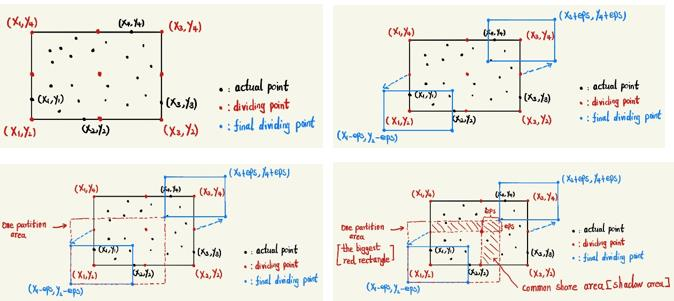


In [4]:
def _bounds_coordinates(bin_bounds):
    lower_cdnts = [[low] for low in  bin_bounds[0][:-1]]
    upper_cdnts = [[high] for high in bin_bounds[0][1:]]
    
    # super stupid implementation, optimization needed
    for bound in bin_bounds[1:]:
        lower_tmp = []
        upper_tmp = []
        
        for bc in bound[:-1]:
            lower_tmp.extend([lc + [bc] for lc in lower_cdnts])
        lower_cdnts = lower_tmp
        
        for bc in bound[1:]:
            upper_tmp.extend([uc + [bc] for uc in upper_cdnts])
        upper_cdnts = upper_tmp

    
    return np.array(lower_cdnts), np.array(upper_cdnts)

@timeit
def spatial_partition(dataset, n_partitions, eps):
    """
    n_partitions: tuple with shape correspoding to dataset dimension
    """
    tp_par = n_partitions
    num_par = np.prod(n_partitions)  # prod(2，2)= 2*2 = 4个partition
    
    # cut bins
    bounds = np.concatenate(([np.min(dataset, axis=0)], [np.max(dataset, axis=0)]), axis=0)     # 2 * D
    bounds_dim = bounds.T   # D * 2,
    # bounds:[[ 0.75  2.95] [41.3  27.85]] get column values
    # tp_par:(2, 2)
    # bounds_dim:[[ 0.75 41.3 ] [ 2.95 27.85]] get row column values 
    # bin_bounds:[array([ 0.75 , 21.025, 41.3  ]), array([ 2.95, 15.4 , 27.85])]
    

    
    bin_bounds = []
    for i in range(len(tp_par)):
        dim_bins = np.linspace(*bounds_dim[i], tp_par[i]+1, endpoint=True) #根据取值范围来和partition number来找到分割点
        bin_bounds.append(dim_bins)
        
    
    
    lower_bounds, upper_bounds = _bounds_coordinates(bin_bounds)
    lower_bounds -= eps
    upper_bounds += eps
    # lower_bounds: [[-1.25   0.95 ] [19.025  0.95 ] [-1.25  13.4  ] [19.025 13.4  ]]
    # upper_bounds: [[23.025 17.4  ] [43.3   17.4  ] [23.025 29.85 ] [43.3   29.85 ]]
    
    # scatter points into bins with eps
    indexed_data = []
    for id_pts in range(len(dataset)):     # index of point in dataset
        # 判别每一个点应该归属到哪个partition里面
        for id_ptt in range(num_par):
            if not (dataset[id_pts] > lower_bounds[id_ptt]).all():
                continue
            if not (dataset[id_pts] < upper_bounds[id_ptt]).all():
                continue
            indexed_data.append([id_ptt, id_pts])
    # build rdd to assign with worker
    res = sc.parallelize(indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res


## Local DBSCAN Stage: A picture example to illustrate the process
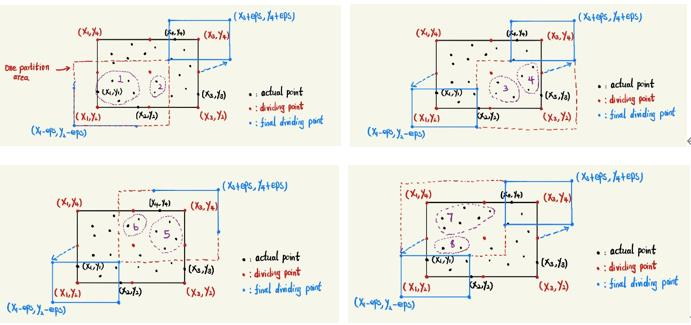

In [5]:
def local_dbscan(partioned_rdd, method='matrix', metric='euclidian'):
    
    dataset = np.array([b_dataset.value[idp] for idp in partioned_rdd])
    
    if method == 'matrix':
        dbscan_obj = MatrixDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    else:
        dbscan_obj = NaiveDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    dbscan_obj.predict()
    is_core_list = dbscan_obj._find_core_pts()
    
    return list(zip(zip(partioned_rdd, is_core_list), dbscan_obj.tags))



## Merge Stage: A picture example to illustrate the process
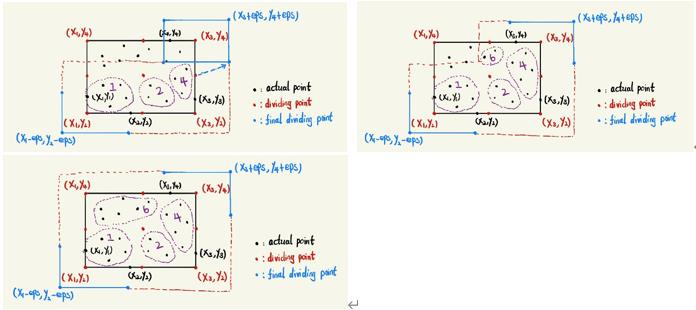

In [6]:
@timeit
def merge(local_tags, dataset):
    global_tags = [UNKNOWN] * len(dataset)
    is_tagged = [0] * len(dataset)
    last_max_label = 0 # 累积label看总共有多少

    
    for local in local_tags:
        np_local = np.array(local[-1])
        # np_local: [[(1, 0) -2] [(2, 0) -2] [(3, 0) -2] [(4, 0) -2] [(5, 0) -2]
        
        np_local[:, -1] += last_max_label            
        # np_local + last_max_label: [[(1, 0) -2] [(2, 0) -2] [(3, 0) -2] [(4, 0) -2] [(5, 0) -2]

        last_max_label = np.max(np_local[:, -1]) 
        
        
        # check and merge overlapped points        
        tagged_indices = np.nonzero(is_tagged)[0] #看多少个点是被上一轮标记过的点 点自己的位置就代表自己那个点
        for tmp_i in range(len(np_local)):
            # should do tag check
            (p_id, is_core), label = np_local[tmp_i]
            if p_id in tagged_indices and is_core==1:  #如果有被上一轮tagged 并且 是core point 那么就共用tag
                np_local[-1][np_local[-1]==label] = global_tags[p_id] #直接把属于这一类的point全部同步了
        
        
        
        # update global tags
        for (p_id, is_core), label in np_local:
            if is_tagged[p_id]==1:
                continue
            global_tags[p_id] = label  # 没有出现的point才去更新他的label
            is_tagged[p_id] = 1        # 然后标记他被打过标签
    return global_tags

## Initiation of the dataset and Execution of the Parallel Matrix DBSCAN algorithm

In [7]:
# initiate the basic information 
test_file = 'jain.txt'
dataset = np.array(load_data_label(test_file))
eps = 2
min_pts = 18
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)
partition_tuple = (2,2)   # define how many partition we need: 2*2 = 4 (partition0, partition1, partition2, partition3)
verbose=True              # whether print the detail information about the partitions 






print('Parallel_Matrix_DBSCAN:')
# Partition stage:
partitioned_rdd = spatial_partition(dataset, partition_tuple, eps)
# Local Matrix DBSCAN stage:
local_tags = partitioned_rdd.mapValues(lambda x: local_dbscan(x, method='matrix', metric='euclidian')).collect()
# Merge stage:    
result_tags = merge(local_tags, dataset)
    
    
    
    
    
# print the detail information about the partitions
if verbose:
    p = partitioned_rdd.collect()
    print('Partition info:')
    for i in range(len(p)):
        print('partition ', p[i][0],', num of points: ', len(p[i][1]), ', num of clusters: ', len(np.unique(np.array(local_tags[i][-1])[:, 1])))
        print('Number of Clusters:')


Parallel_Matrix_DBSCAN:
spatial_partition time cost: 44.960737228393555ms
merge time cost: 1.9965171813964844ms
Partition info:
partition  0 , num of points:  114 , num of clusters:  5
Number of Clusters:
partition  1 , num of points:  225 , num of clusters:  8
Number of Clusters:
partition  2 , num of points:  110 , num of clusters:  2
Number of Clusters:
partition  3 , num of points:  60 , num of clusters:  2
Number of Clusters:
